In [1]:
from utils import * 
from algorithms import *
from agents import *

In [2]:
numRounds, numPeriods, numSteps = 1, 10000, 10
numBuyers, numSellers, numTokens = 4, 4, 4
gameTypes, seed = '1111', 42
disclosure = ['bids', 'asks', 'currentBid', 'currentBidIdx','currentAsk', 'currentAskIdx', 'buy', 'sell', 'price', 'sale']
depth = 1
gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]
numStates = 18
episodeLength = 1
numTrajectories = 10
gamma=0.99
std_init = 0.5
std_decay = 0.995
std_min = 0.015
lr = 0.0003
buyers = [Reinforcer(gameData, disclosure, index=0, buyer=1, reinforcer=1, numStates = numStates, algo='VPGContinuous',
                     algoArgs = [numStates, episodeLength, numTrajectories, gamma, std_init, std_decay, std_min, lr]),
          ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
          ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
          ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0)]
sellers = [ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0)]
log = Log(gameData, disclosure)
rnd = 0

0.5 0.995 0.015


In [ ]:
print_interval = 1
for rnd in range(numRounds):
    startRounds(gameData, log, buyers, sellers, rnd)
    print(log.roundData.tail(1).buyerValues.item())
    print(log.roundData.tail(1).sellerCosts.item())
    score1, score2 = 0.0, 0.0
    ss1, ss2 = 0.0, 0.0
    for period in range(numPeriods):
        startPeriods(buyers, sellers)
        period_bids = []
        for step in range(numSteps):
            # start
            startSteps(buyers, sellers)

            # set state
            buyers[0].state = generateState(buyers[0], disclosure, depth)

            # trade
            bids, asks = collectOffers(buyers, sellers)
            period_bids.append(np.round(bids[0]))
            currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
            price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)
            bprofit, sprofit = 0, 0
            if price > 0:
                buyers[currentBidIdx].transact(price)
                sellers[currentAskIdx].transact(price)
                bprofit = buyers[currentBidIdx].stepProfits
                sprofit = sellers[currentAskIdx].stepProfits
            if currentBidIdx == 0:
                score1 += bprofit
                ss1 += bprofit
            elif currentBidIdx == 1:
                score2 += bprofit
                ss2 += bprofit
                
            log.addStep([rnd, period, step, bids, asks, currentBid, currentBidIdx, currentAsk, currentAskIdx, buy, sell, price, price>0, bprofit, sprofit])
            observe(buyers, sellers, log.disclose())
            endSteps(buyers, sellers)
            buyers[0].newState  = generateState(buyers[0], disclosure, depth)

            if step == numSteps - 1:
                buyers[0].done = True
            else:
                buyers[0].done = False

            agentsObserve(buyers, sellers)
            agentsTrain(buyers, sellers)

        endPeriods(buyers, sellers)
        if period%300==0:
            print('\t',ss1/300, ss2/300, round(buyers[0].algo.std,2), period_bids)
            ss1 = 0
            ss2 = 0
        #if period%print_interval==0:
        #    print(step, round(score1 / print_interval, 2), round(score2 / 100, 2), round(buyers[0].algo.mean, 2), round(buyers[0].algo.std, 2), round(buyers[0].algo.action.item(), 2), period_bids)
        #    score1 = 0.0
        #    score2 = 0.0
    endRounds(buyers, sellers)

[[85.82202637 81.73001813 81.63077519 77.98802756]
 [86.00286066 81.75851481 77.79014457 77.22312836]
 [83.24607464 78.75300079 77.92916939 77.73215368]
 [81.78455651 76.72373723 71.09604113 70.44124563]]
[[42.84624139 45.55309494 45.88317457 51.95146854]
 [40.61548525 47.08281665 48.26232262 56.1070403 ]
 [42.80119778 46.68836691 49.39779518 50.24920035]
 [47.07267989 47.93213437 48.90976077 59.15714846]]
	 0.0546859407801945 0.19550506679883625 0.5 [42.0, 56.0, 64.0, 32.0, 73.0, 89.0, 45.0, 53.0, 60.0, 69.0]
	 59.04804116285676 54.30101964735524 0.43 [53.0, 82.0, 60.0, 65.0, 55.0, 55.0, 83.0, 59.0, 51.0, 65.0]
	 62.22166528810262 52.2195016038156 0.37 [79.0, 66.0, 58.0, 67.0, 58.0, 61.0, 74.0, 75.0, 65.0, 85.0]
	 67.58610791173523 48.41642989779025 0.32 [84.0, 70.0, 65.0, 62.0, 70.0, 46.0, 75.0, 57.0, 55.0, 70.0]
	 71.95617774025892 49.85161794503601 0.27 [76.0, 82.0, 76.0, 65.0, 76.0, 78.0, nan, nan, nan, nan]
	 73.27168597182649 50.77013759094346 0.24 [73.0, 77.0, 71.0, 68.0, 63.0,

In [3]:
buyers[0].algo.std = 0.015
buyers[0].algo.lr = 0.00005
buyers[0].algo.std_min = 0.015

In [25]:
a = (torch.tensor(buyers[0].state )-buyers[0].algo.state_mean)/(torch.sqrt(buyers[0].algo.state_std))
formatted_elements = [f'{val:.4f}' for val in a.tolist()]
formatted_tensor = "[" + ", ".join(formatted_elements) + "]"
print(formatted_tensor)

[2.6553, 1.5461, 2.4677, 1.5956, -1.6807, 1.5794, 0.0007, 0.0127, 0.7345, 0.0007, 3.4238, -3.8868, -0.7338, 6.1308, 5.9766, 6.2412, -0.8732, -4.6338]


In [26]:
(torch.tensor(buyers[0].state )-buyers[0].algo.state_mean)/(torch.sqrt(buyers[0].algo.state_std))

tensor([ 2.6553e+00,  1.5461e+00,  2.4677e+00,  1.5956e+00, -1.6807e+00,
         1.5794e+00,  7.4672e-04,  1.2698e-02,  7.3446e-01,  7.4672e-04,
         3.4238e+00, -3.8868e+00, -7.3380e-01,  6.1308e+00,  5.9766e+00,
         6.2412e+00, -8.7318e-01, -4.6338e+00], dtype=torch.float64)

In [27]:
log.stepData.tail(500).groupby('currentBidIdx').sum()

,rnd,period,step,bids,asks,currentBid,currentAsk,currentAskIdx,buy,sell,price,sale,bprofit,sprofit
currentBidIdx,,,,,,,,,,,,,,
0,0,683853,916,"[73.56195591390133, 55.9, 50.0, 54.3, 69.54012...","[48.4, 43.0, 59.5, 49.8, 56.9, 67.6, 52.9, 65....",12778.61906,9360.6,245,181,181,11069.60953,181,3788.748085,2714.948031
1,0,453490,534,"[68.00539199262857, 69.4, 55.2, 56.5, 69.08712...","[62.9, 49.5, 52.3, 59.9, 50.2, 70.9, 43.5, 57....",8992.50000,6093.3,154,120,120,7542.90000,120,2374.893379,2051.976245
2,0,430663,482,"[65.27838420122862, 64.5, 80.9, 71.1, 69.61488...","[47.1, 58.1, 50.5, 60.9, 61.0, 57.2, 71.6, 68....",8585.70000,5854.1,156,114,114,7219.90000,114,1955.106967,2003.662672
3,0,321244,318,"[69.08349752426147, 44.1, 66.2, 70.7, 70.12844...","[65.3, 47.1, 69.7, 61.8, 47.0, 58.0, 64.2, 64....",6305.80000,4244.1,115,85,85,5274.95000,85,1461.348510,1445.565428


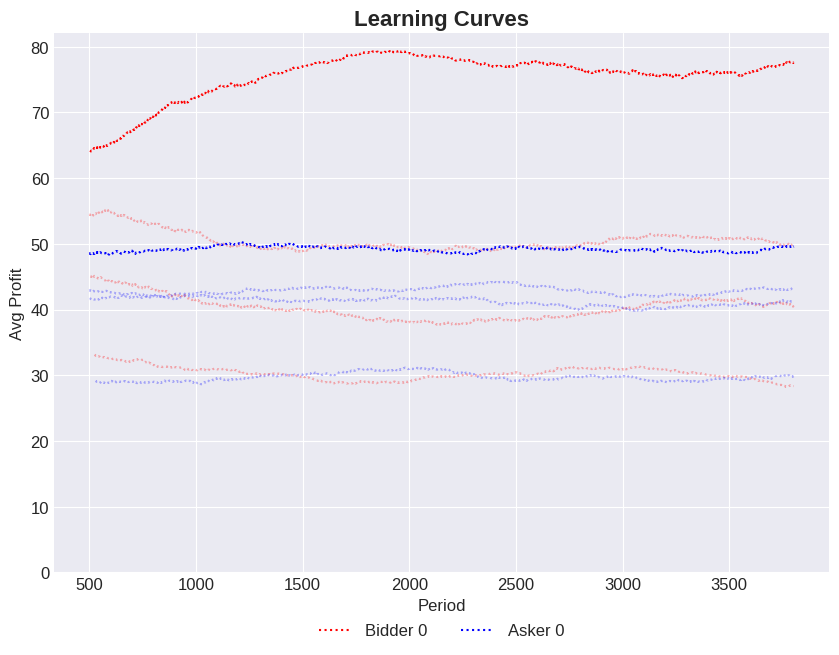

In [29]:
log.graphLearning(rolling_window = 500, trackBuyersIdx=[0], trackSellersIdx=[0])

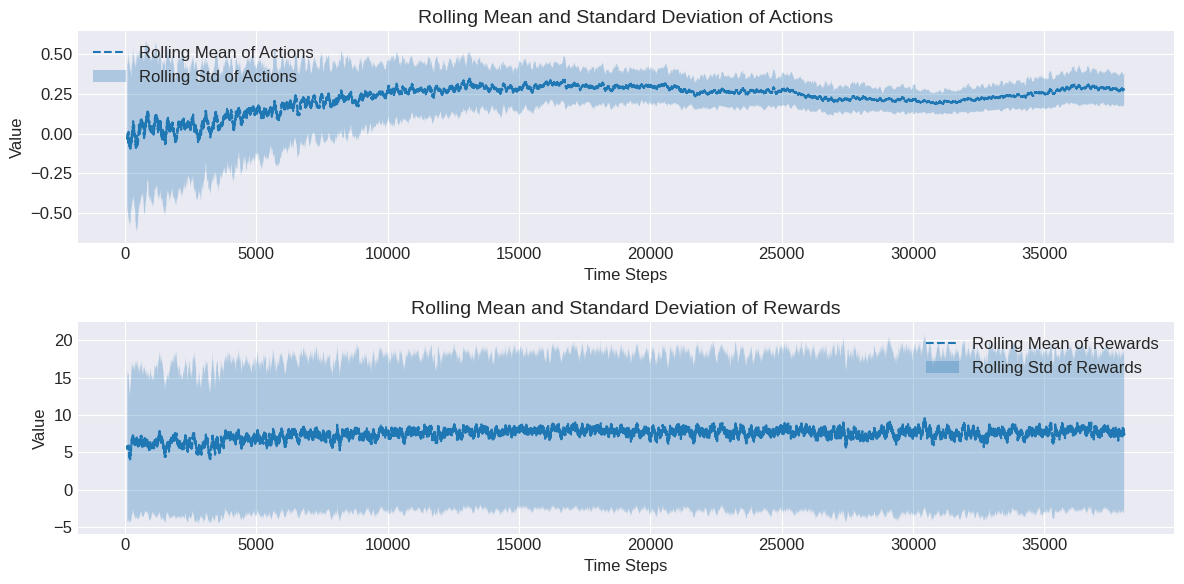

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'memory' contains your data
memory = pd.DataFrame(buyers[0].algo.memory, columns=['state', 'action', 'reward', 'newState', 'done'])

# Calculate the rolling mean and standard deviation for actions and rewards
window_size = 100  # You can adjust the window size as needed
rolling_action_mean = memory['action'].rolling(window=window_size).mean()
rolling_reward_mean = memory['reward'].rolling(window=window_size).mean()
rolling_action_std = memory['action'].rolling(window=window_size).std()
rolling_reward_std = memory['reward'].rolling(window=window_size).std()

# Plot the rolling means and standard deviations separately for actions and rewards
plt.figure(figsize=(12, 6))

# Plot Rolling Mean and Std for Actions
plt.subplot(2, 1, 1)
plt.plot(rolling_action_mean, label='Rolling Mean of Actions')
plt.fill_between(
    range(len(memory)),
    rolling_action_mean - rolling_action_std,
    rolling_action_mean + rolling_action_std,
    alpha=0.3,
    label='Rolling Std of Actions'
)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.title('Rolling Mean and Standard Deviation of Actions')

# Plot Rolling Mean and Std for Rewards
plt.subplot(2, 1, 2)
plt.plot(rolling_reward_mean, label='Rolling Mean of Rewards')
plt.fill_between(
    range(len(memory)),
    rolling_reward_mean - rolling_reward_std,
    rolling_reward_mean + rolling_reward_std,
    alpha=0.3,
    label='Rolling Std of Rewards'
)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.title('Rolling Mean and Standard Deviation of Rewards')

plt.tight_layout()
plt.show()


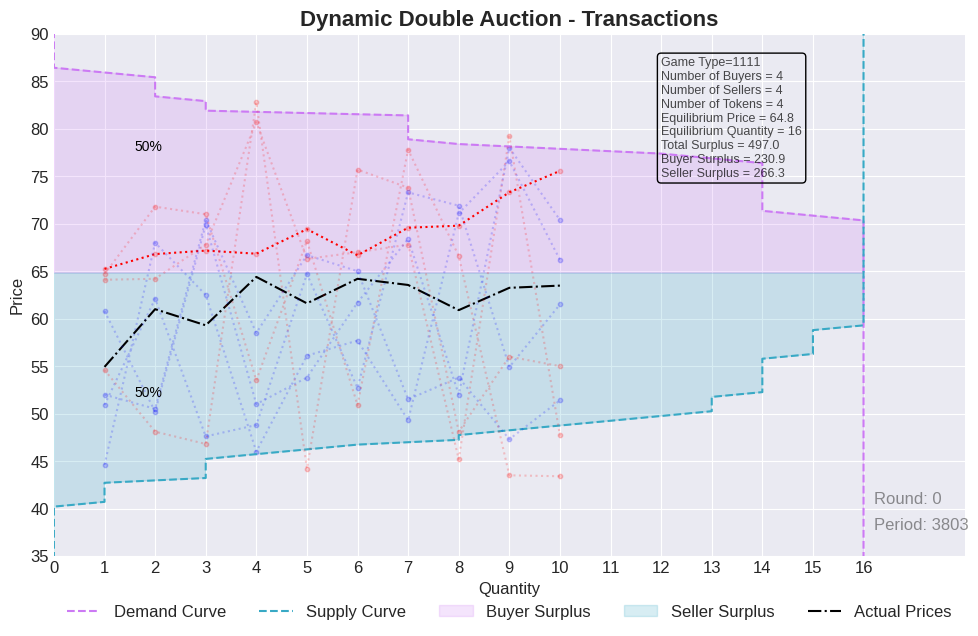

In [31]:
log.graphSales(0, period, trackBuyersIdx=[0], trackSellersIdx=[])

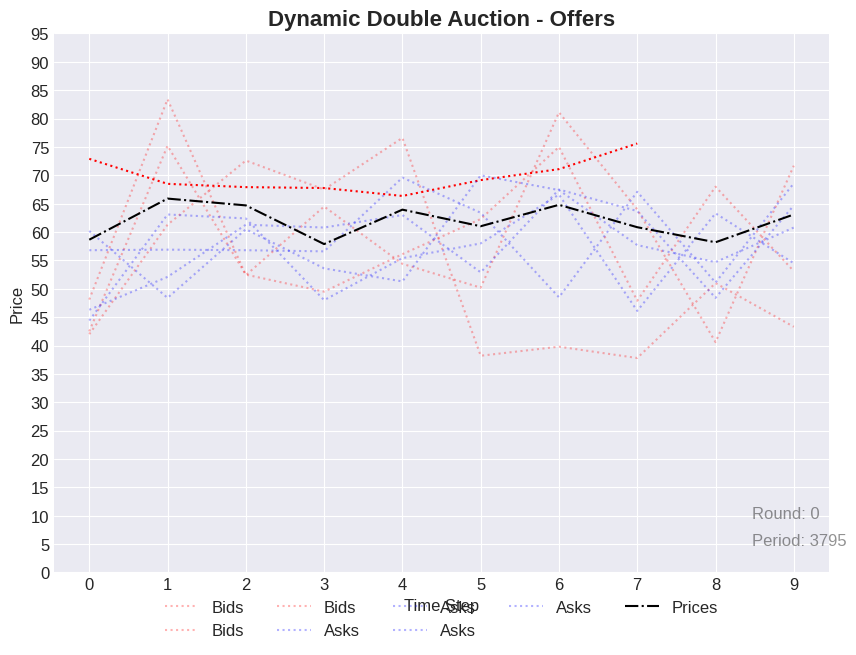

In [32]:
log.graphOffers(0, period-8, trackBuyersIdx=[0], trackSellersIdx=[])

In [35]:
log.graphTraining(maxNumPeriods=period-1, skip = int((period-1)/50), trackBuyersIdx = [0])